This notebook provides an implementation for the paper EFFICIENT AND SCALABLE GRAPH GENERATION THROUGH ITERATIVE LOCAL EXPANSION: [https://arxiv.org/pdf/2312.11529](https://arxiv.org/pdf/2312.11529)

In [ ]:
!pip3 install -q torch_geometric
!pip3 install -q diffusers
!pip3 install torch_scatter

^C
ERROR: Operation cancelled by user


# Import required librairies

In [178]:
import numpy as np
import math
from pprint import pprint

import torch
from torch.nn import Dropout, LayerNorm, Linear, Module, ModuleList, Sequential, ReLU
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader as torchDataLoader
import torch.nn.functional as F


from torch_geometric.nn import TransformerConv          # edge-aware
from torch_scatter import scatter_mean             # for e→v summary


import torch_geometric
from torch_geometric.utils import get_laplacian
from torch_geometric.data import Data, Batch, DataLoader, InMemoryDataset, download_url 
from torch_geometric.utils import erdos_renyi_graph, to_dense_adj, dense_to_sparse, to_networkx, from_networkx
from torch_geometric.nn import GCNConv, GINConv, GATConv

import networkx as nx
import matplotlib.pyplot as plt
import os

from diffusers import DDPMScheduler
from tqdm.auto import trange

ModuleNotFoundError: No module named 'torch_scatter'

In [103]:
print("torch_geometric version:", torch_geometric.__version__)
print("torch version:", torch.__version__)

torch_geometric version: 2.6.1
torch version: 2.6.0+cu124


# Creating datasets for training

## Erdos renyi dataset

In [104]:
def generate_erdos_renyi_graphData(num_nodes=10, p=0.5):
    edge_tensor = erdos_renyi_graph(num_nodes, p, directed=False)  # shape [2, num_edges]

    # Create graph nodes, values all 0
    nodes = torch.zeros((num_nodes, 1)) # shap4 [num_nodes, 1], any node feature is a single scalar 0.
    # each node in this tensor is assigned an id based on its index 0...num_nodes-1 
    # these ids are the ones used in edge_tensor, it is possible that there are no edges... 
    
    # Create Data object for graph
    graphData = Data(x=nodes, edge_index=edge_tensor)
    
    return graphData

graphDataset = generate_erdos_renyi_graphData()
# G = to_networkx(graph, to_undirected=True)
# plt.figure()
# nx.draw(G, with_labels=True, node_size=500)
# plt.show()

In [105]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class ErdosRenyiDataset(InMemoryDataset):
    def __init__(self, root, num_graphs=100, transform=None, pre_transform=None, pre_filter=None):
        self.num_graphs = num_graphs

        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for i in range(self.num_graphs):
            data_list.append(generate_erdos_renyi_graphData())

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [106]:
!rm -rf /kaggle/working/data/ER/processed
erdos_renyi_dataset = ErdosRenyiDataset(root='data/ER', num_graphs=10000)

Processing...


Dataset already exists, loading it...
Done.


Done!


In [107]:
print(f"Number of graphs: {len(erdos_renyi_dataset)}")

for g in range(4):
    edge_index = erdos_renyi_dataset[g].edge_index

Number of graphs: 10000


In [108]:
edge_index[:, :1]

tensor([[0],
        [2]])

## Planar graph dataset (generated with plantri)

Command             | Triangulations Written | CPU Time (sec)
--------------------|------------------------|---------------
./plantri -c3 10    | 233                    | 0.00
./plantri -c3 11    | 1,249                  | 0.02
./plantri -c3 12    | 7,595                  | 0.04
./plantri -c3 13    | 49,566                 | 0.16
./plantri -c3 14    | 339,722                | 1.11
./plantri -c3 15    | 2,406,841              | 8.01
./plantri -c3 16    | 17,490,241             | 61.98
./plantri -c3 17    | 129,664,753            | 504.53

In [109]:
import networkx as nx

def graph6_to_data(g6_path):
    print(f"Loading graphs from {g6_path}")
    
    with open(g6_path, "rb") as f:
        graph_nx = nx.read_graph6(f)

    print(f"Read {len(graphs_nx)} graphs from {g6_path}")
    return graphs_nx

In [110]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class PlanarDataset(InMemoryDataset):
    def __init__(self, root, g6_dir=None, transform=None, pre_transform=None, pre_filter=None):

        g6_files = [os.path.join(g6_dir, f) for f in os.listdir(g6_dir) if f.endswith(".g6")]
        self.g6_files = g6_files
        
        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for file in self.g6_files:
            nx_graphs = graph6_to_data(file)
            data_list += [from_networkx(g) for g in nx_graphs]

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [111]:
#planar_dataset = PlanarDataset(root='data/PL', g6_dir="/kaggle/input/planar-graphs-g6-dataset")

# Coarsening sampling

We need to sample coarsening sequences from $\Pi_F(G)$ that only use contraction sets in $F(G) = \mathcal{E}$, meaning each coarsening step only merges some edges of the graph. 

We sample in $\Pi_F(G)$ by sampling coarsening sequences from a "latent" distribution $q(\pi | G)$. To sample from $q(\pi | G)$, we associate a cost to each possible coarsening set at all coarsening steps, for now the uniform cost.

The below function extracts all possible coarsening sets at a given step (given a graph).

tensor([[0, 1],
        [0, 2],
        [0, 4],
        [1, 0],
        [1, 2],
        [1, 4],
        [1, 6],
        [1, 7],
        [1, 8],
        [1, 9]])
Total number of nodes: 10


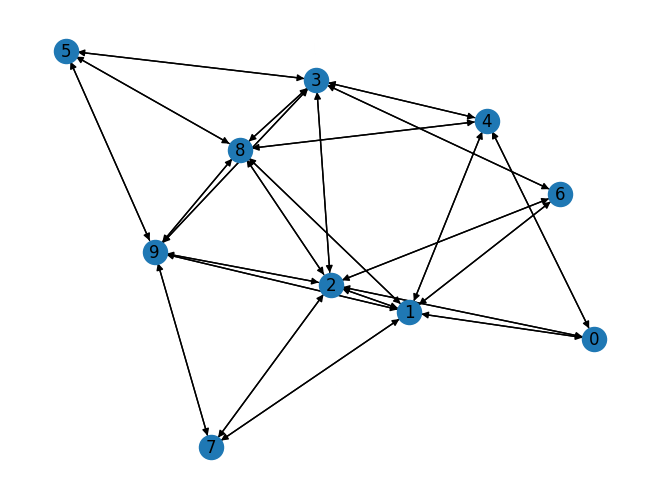

In [112]:
def get_candidate_contraction_sets(G: Data):
    # make sure no self loop on nodes here!
    edge_index = G.edge_index # 2, num_edges (tensor)
    u, v       = edge_index[0], edge_index[1]

    # remove self edges
    nonself = (u != v)
    u_ns, v_ns = u[nonself], v[nonself]

    candidates = torch.stack([u_ns, v_ns], dim=1)
    return candidates

# test
test_graph = erdos_renyi_dataset[10]
nx.draw(to_networkx(test_graph), with_labels=True)

test_candidates = get_candidate_contraction_sets(test_graph)
print(test_candidates[:10])

test_current_num_nodes = test_graph.num_nodes
print("Total number of nodes:", test_current_num_nodes)

The below function creates a dense adjency matrix given a graph by looking at all of its edges.

In [113]:
def get_graph_adj(edge_index: torch.LongTensor, num_nodes: int):
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)
    adj = adj[0]
    return adj

# test
test_graph_adj = get_graph_adj(test_graph.edge_index, test_graph.num_nodes)
#indices = (graph_adj == 1).nonzero(as_tuple=False)
print(test_graph_adj)

tensor([[0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0., 1., 0., 1., 1., 0.]])


<span style="color:red">The uniform cost should be replaced by  local-variation cost of Loukas (2018) from the paper otherwise model won't train well!</span>

In [114]:
def get_uniform_cost(candidate_contractions: torch.LongTensor, graphData: Data): # can also be based on G0, P1...P{l-1}
    # graphData not used, just used for compatibility
    num_candidates = candidate_contractions.shape[0]

    return torch.tensor([np.random.rand() for _ in range(num_candidates)], dtype=torch.float32)

# test
get_uniform_cost(test_candidates, test_graph)

tensor([0.8256, 0.6088, 0.8830, 0.7396, 0.5321, 0.4121, 0.1519, 0.9449, 0.6495,
        0.0202, 0.3726, 0.4539, 0.4608, 0.0863, 0.5507, 0.2970, 0.0328, 0.7607,
        0.5980, 0.3336, 0.4140, 0.7251, 0.1255, 0.1411, 0.7219, 0.7867, 0.5477,
        0.4968, 0.0673, 0.2374, 0.4630, 0.5441, 0.1329, 0.1878, 0.5577, 0.5297,
        0.4951, 0.1134, 0.3153, 0.1829, 0.4489, 0.9999, 0.0994, 0.8164, 0.7491,
        0.8264, 0.7604, 0.1340])

Better cost function inspired from the paper. Try to conserve structure. The idea is that after computing eigenvectors of the laplacian, in each vector, the difference between coordinates i (first node) and j (second node) is either high or low. If low, this means the two nodes diffuse signals similarly? if high, they shouldnt be removed. We compute the sum of squared differences and   

In [115]:
def get_improved_cost(
    candidate_contractions: torch.LongTensor,   # [E', 2]  candidate contractions
    graphData: Data,
    k:int = 8,
) -> torch.Tensor:                  # → [E']  cost per edge
    """
    Cheap surrogate of Loukas' local-variation cost.
    Computes ‖A[u]-A[v]‖₂ for every candidate edge (u,v).
    """
    edge_index = graphData.edge_index
    num_nodes = graphData.num_nodes
    
    adj = get_graph_adj(edge_index, num_nodes)
    deg = adj.sum(1)
    L   = torch.diag(deg) - adj

    # First-k eigenvectors
    evals, evecs = torch.linalg.eigh(L)
    F = evecs[:, :min(k, num_nodes-1)] # [N, k]

    u, v = candidate_contractions.t() # [2, E'] -> [E'] and [E']
    diffs = F[u] - F[v] # [E',k] - [E',k]
    
    cost  = (diffs**2).sum(dim=1) #[E']

    return cost

# test
get_improved_cost(test_candidates, test_graph)

tensor([1.2059, 0.9438, 1.8651, 1.2059, 0.5478, 1.0731, 1.0456, 1.2684, 0.8104,
        0.8066, 0.9438, 0.5478, 0.6765, 1.0706, 1.0561, 0.5604, 1.0166, 0.6765,
        1.5482, 1.7643, 1.6600, 1.5717, 1.5154, 1.8651, 1.0731, 1.5482, 1.7228,
        1.7643, 1.6824, 1.8128, 1.0456, 1.0706, 1.6600, 1.2684, 1.0561, 1.9424,
        0.8104, 0.5604, 1.5717, 1.7228, 1.6824, 1.9485, 0.8066, 1.0166, 1.5154,
        1.8128, 1.9424, 1.9485])

Below is the implementation of the rnd_greedy_min_cost_part algorithm 2 from the paper. Basically this algorithm runs at each step, and given number of nodes to remove, iteratively selectes the best contraction set (edges in our case) to use for coarsening, until the number of nodes to remove is obtained.

In [116]:
def rnd_greedy_min_cost_part(
    candidate_contractions: torch.LongTensor, 
    cost_function, 
    current_graph, # added this parameter to compute cost, it contains current_graph on which coarsening is done
    num_nodes_to_remove: int, 
    current_num_nodes: int,
    rand_lambda: float = 1.0,
):
    """
    Algo 2
    candidate_contractions [num_candidates, 2] each candidate is a pair of nodes (edge)
    Greedily picks contraction candidates until at least num_nodes_to_remove are merged.
    """

    num_candidates = candidate_contractions.size(0)    
    alive = torch.ones(num_candidates, dtype=torch.bool) # check for already selected contractions, True means not selected
    marked  = torch.zeros(current_num_nodes, dtype=torch.bool) # mark nodes already contracted...
    
    costs  = cost_function(candidate_contractions, current_graph)
    
    # each cost is a rand float between 0 and 1    

    picked = [] # picked contractions idx
    removed = 0

    #print(f"inside rnd_greedy_min_cost_part: i need to remove {num_nodes_to_remove} nodes")
    while (removed < num_nodes_to_remove and alive.any()):
        masked_costs = costs.masked_fill(~alive, float('inf'))
        idx = torch.argmin(masked_costs).item()
        
        if torch.rand(1).item() > rand_lambda: # simulate Bernoulli, after selecting an edge to remove, sample a Bernoulli and while it is not 0 never select it again and continue process
            alive[idx] = False
            continue 

        selected_nodes = candidate_contractions[idx] # this contains the selected edge (pair of nodes) to remove
        
        if marked[selected_nodes].any(): # maybe one of the two selected nodes is already used in some other edge that needs to be removed, then never select edge again and continue process
            alive[idx] = False
            continue

        # otherwise mark it as selected set both of the nods to unalive and continue
        
        marked[selected_nodes] = True
        alive[idx] = False
        picked.append(idx)
        #print(f"We find a new edge to remove: {candidate_contractions[idx]}, removing it will remove: {selected_nodes.numel() - 1} nodes.")
        removed +=  selected_nodes.numel() - 1 # merging always keeps one node
        #print(f"inside rnd_greedy_min_cost_part: fo far i removed {removed} nodes.")

    #print(f"I might have stopped because alive.any(): {alive.any()}")
    if picked:
        picked_idx = torch.tensor(picked, dtype=torch.long)
        return candidate_contractions[picked_idx]
    else:
        print("rnd_greedy_min_cost_part Error")

# test
# for remove_n in range(1, current_num_nodes // 2): # max number of removable nodes
#     test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_cost, remove_n, current_num_nodes)
#     print(f"Removed {remove_n} nodes with contractions: {test_partitioning}")
    
test_num_nodes_to_remove = 2
# uniform cost also possible with  get_uniform_cost instead of get_improved_cost
test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_improved_cost, test_graph, test_num_nodes_to_remove, test_current_num_nodes)
print(test_partitioning)

tensor([[1, 2],
        [3, 9]])


Below is a visualization function that assigns a unique color to each cluster id (as long as there are less than 34 clusters in total), and then displays the graph by coloring clusters (all nodes in a given cluster will share that cluster color). 

In [117]:
def visualize_clusters(G: Data, partitioning: torch.Tensor):
    # Convert to NetworkX
    if getattr(G, 'edge_attr', None) is not None:
        G_nx = to_networkx(G, to_undirected=True, edge_attrs=["edge_attr"])
        raw_attrs = {
            (u, v): int(d["edge_attr"])
            for u, v, d in G_nx.edges(data=True)
        }
    else:
        G_nx = to_networkx(G, to_undirected=True)
        raw_attrs = {}

    # Create a color map for each node
    color_map = ['lightgray'] * G.num_nodes  # default color

    # Assign a unique color for each cluster
    colors = [
        'red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'brown',
        'pink', 'olive', 'chocolate', 'lime', 'navy', 'teal', 'coral', 'gold',
        'magenta', 'orchid', 'salmon', 'darkgreen', 'deepskyblue', 'slateblue',
        'violet', 'maroon', 'turquoise', 'indigo', 'darkorange', 'crimson',
        'steelblue', 'darkviolet', 'khaki', 'cadetblue', 'hotpink', 'mediumseagreen'
    ]

    cluster_id_to_color = {}
    
    for cluster_id, cluster in enumerate(partitioning):
        color = colors[cluster_id % len(colors)]
        cluster_id_to_color[cluster_id] = color
        for node in cluster.tolist():
            color_map[node] = color
        print(f"Cluster {cluster_id} has color {colors[cluster_id % len(colors)]}")

    edge_colors = []
    for u, v in G_nx.edges():
        a = raw_attrs.get((u, v), None)
        edge_colors.append('red' if a == -1 else 'black')

    # Draw the graph
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw(G_nx, pos, node_color=color_map, with_labels=True, edge_color=edge_colors)
    plt.show()

    return cluster_id_to_color

Cluster 0 has color red
Cluster 1 has color green


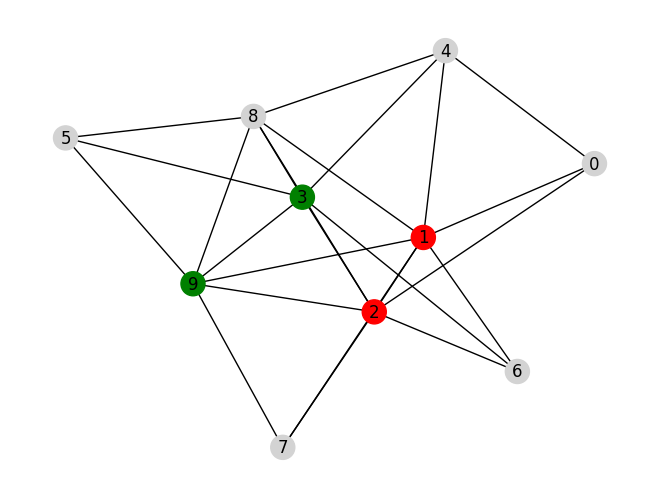

Cluster 0 has color red


In [118]:
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)
print(f"Cluster 0 has color {test_cluster_id_to_color[0]}")

In [119]:
def has_edge_undirected(edge_index, u, v):
    src, dst = edge_index
    return ((src == u) & (dst == v)).any() or ((src == v) & (dst == u)).any()

has_edge_undirected(test_graph.edge_index, 3, 5)

tensor(True)

The below function completes a partitioning tensor containing all coarsening sets (pairs of nodes forming an edge that need to be merged) with the remaining sets that will not be merged for future code compatibility. The remaining sets not to be merged will all contain leftover nodes stacked with themselves, and concatenated at the end of the partitioning tensor. For instance one left over node i will be concatenated as [i, i].

In [120]:
def augment_with_singletons(partitioning: torch.LongTensor, num_nodes: int, debug=False):
    """
    Given partitioning of shape [P,2]
    return a new LongTensor of shape [P+U, K'] where rows 0..P-1
    are your old clusters, and rows P..P+U-1 each contain exactly
    one leftover node as a single cluster.
    """
    # flatten and find which nodes were clustered
    clustered = partitioning.unique() # no dim specified -> unique of the flattened partitioning
    num_initial_clusters = partitioning.shape[0]
    
    all_nodes = torch.arange(num_nodes, device=partitioning.device)
    
    mask = torch.ones(num_nodes, dtype=torch.bool, device=partitioning.device)
    mask[clustered] = False
    
    leftover = all_nodes[mask]  # shape [U]

    # now make each leftover its own cluster of size 1, with itself, little trick
    singletons = torch.stack([leftover, leftover], dim=1) # [U, 2]
    
    if singletons.numel() > 0:
        partitioning = torch.cat([partitioning, singletons], dim=0)

        if debug:
            for i, node_id in enumerate(leftover.tolist()):
                cluster_id = num_initial_clusters + i
                print(f"Leftover node {node_id} assigned to singleton cluster {cluster_id}")

    return partitioning # ideally also explain what id each solo cluster got for coloring later!

# test 
print(f"Number of clusters before: {test_partitioning.shape[0]}")
test_augmented_partitioning = augment_with_singletons(test_partitioning, test_current_num_nodes, debug=True)
print(f"Number of clusters after: {test_augmented_partitioning.shape[0]}")

Number of clusters before: 2
Leftover node 0 assigned to singleton cluster 2
Leftover node 4 assigned to singleton cluster 3
Leftover node 5 assigned to singleton cluster 4
Leftover node 6 assigned to singleton cluster 5
Leftover node 7 assigned to singleton cluster 6
Leftover node 8 assigned to singleton cluster 7
Number of clusters after: 8


The below function builds a matrix P mapping all nodes to their clusters (left over nodes are considered as single node clusters) returns [num_clusters, N] for N nodes.

In [121]:
def build_P(num_nodes: int,
            partitioning: torch.Tensor):
    """
    num_nodes: N
    partitioning: list of LongTensors, each contains original node‑indices cluster (max 2 nodes per cluster since we only consider edges).
    Returns P of shape [num_clusters, N], where P[c,i]=1 if i belongs to coarse‑node c.
    """
    num_clusters = len(partitioning)

    P = torch.zeros((num_clusters, num_nodes), dtype=torch.float32)
    for c, nodes in enumerate(partitioning):
        P[c, nodes] = 1.0
    return P

# test
test_P = build_P(test_current_num_nodes, test_augmented_partitioning)
print(test_P)

tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


Each row corresponds to one cluster id, each column corresponds to one node. This can be reused to compute the expansion step GT as each cluster super node will need to be expanded back to however many nodes it contains.

The below function creates an adjency matrix for clusters. Two clusters which initially contained nodes connected to each other will end up connected. Self loops for one cluster are removed by filling the diagonal of this matrix with 0s.

In [122]:
def get_cluster_adj(P: torch.FloatTensor,
                        A: torch.FloatTensor):
    # P: [C, N]; A: [N, N]
    M = P @ A @ P.t()       # [C, C], computes inter cluster links, if any two clusters initially had nodes connected they will be connected
    M.fill_diagonal_(0)
    return (M > 0).to(torch.float32)

# test
test_cluster_adj = get_cluster_adj(test_P, test_graph_adj)
print(test_cluster_adj)

tensor([[0., 1., 1., 1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 0., 0.]])


The below function coarsens a graph given a partitioning containing coarsening sets (a set can be a cluster containing two nodes to merge, or a left over node copied twice that shouldn't be merged). It uses previous functions to returned the coarsened graph as well as the node-cluster mapping matrix that was used to build it.

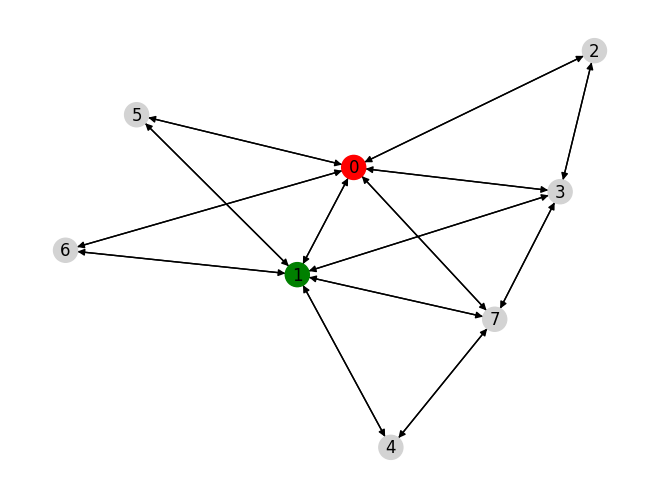

In [123]:
def coarsen_graph(G: Data, partitioning: torch.LongTensor):
    """
    Merge each row of partitioning into a single super‐node.
    Unclustered nodes are nodes j not appearing in any row of partitioning.
    Edges between any two super‐nodes exist iff any member nodes in both were previously connected in G.
    G{l}->G{l+1}
    """
    
    N = G.num_nodes

    augmented_partitioning = augment_with_singletons(partitioning, N)
    
    P = build_P(N, augmented_partitioning) # map nodes to clusters
    graph_adj = get_graph_adj(G.edge_index, N) # get initial graph adjency
    cluster_adj = get_cluster_adj(P, graph_adj) # get clusters adjency

    edge_index, edge_attr = dense_to_sparse(cluster_adj) # convert cluster adj to list of edges
    num_clusters = cluster_adj.size(0)
    
    x = torch.zeros((num_clusters, 1), dtype=torch.float32) # creates a list of cluster nodes
    return Data(x=x, edge_index=edge_index, num_nodes=num_clusters), P # returns a new graph using list of cluster nodes and how they should be connected + the node-cluster mapping matrix 

# test
test_coarsened_graph, test_P = coarsen_graph(test_graph, test_partitioning)

def get_coarse_node_colors(num_clusters: int, cluster_id_to_color: dict) -> list[str]:
    """
    Returns a list of colors for super-nodes in the coarsened graph.
    Each super-node corresponds to a cluster ID.
    """
    color_map = []
    for cluster_id in range(num_clusters):
        color = cluster_id_to_color.get(cluster_id, 'lightgray')
        color_map.append(color)
    return color_map

test_num_clusters = test_coarsened_graph.num_nodes
test_coarse_colors = get_coarse_node_colors(test_num_clusters, test_cluster_id_to_color)

# Step 3: Plot the coarsened graph
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

A sequence of coarsening steps will always reach a single node graph eventually since the starting graph is fully connected and the only way to reach one node is to merge a graph containing two nodes (one edge).

In [124]:
curr = 1
for i in range(10):
    print(curr)
    curr = curr-math.ceil(0.10*curr) # math.ceil(0.10*curr) represents the number of nodes to remove, it is computed in the algorithm that follows.

1
0
0
0
0
0
0
0
0
0


The below function implements rnd_red_seq (algorithm 1) from the paper. It takes as input the initial graph and returns the list of coarsened graphs at each step up to the final single node graph, as well as the contractions history (the node-cluster mappings for building each intermediate coarsened graph).

In [125]:
def rnd_red_seq(G0: Data, min_red_frac=0.1, max_red_frac=0.3, debug=False): # it is not possible to remove more than current_num_nods//2 with edge contraction
    """
    Algo 1
    Returns random coarsening sequence π = (G0, . . . , GL) ∈ ΠF (G) 
    """

    current_graph = G0
    
    if debug: print(f"Initial graph has {G0.num_nodes} nodes.")
    coarsening_seq = [current_graph] # π, will end up containing (G0...GL)
    l = 0

    contractions_history = [] # will contain (P1...PL-1) where Pi is the partitioning matrix used to coarsen Gi into G{i+1}
    
    while current_graph.num_nodes != 1: # removing % of current_num_nods to current_num_nods will always be bigger than 0 and math.ceil 
        # will end up being one until current_num_nods becomes 1 -> last node will be removed 
        l += 1
        reduction_fraction = torch.tensor([1.0])
        reduction_fraction.uniform_(min_red_frac, max_red_frac)  # ρ

        # f already defined as get_cost, for now does not depend on G0/contractions_history
        num_nodes_to_remove = math.ceil(reduction_fraction * current_graph.num_nodes) # m

        candidates = get_candidate_contraction_sets(current_graph) # F(G{l−1}) fetch all possible contractions
        if candidates.numel() == 0:
            print("Error no more edges to contract in rnd_red_seq")
            break
        
        partitioning_l = rnd_greedy_min_cost_part(
            candidate_contractions=candidates,
            cost_function=get_improved_cost,
            current_graph=current_graph,
            num_nodes_to_remove=num_nodes_to_remove,
            current_num_nodes=current_graph.num_nodes
        ) # tensor [C0, C1, …, Ck] # [num_clusters, 2]

        if partitioning_l.numel() == 0:
            print("No contractions picked")
            continue

        # coarsen graph
        if debug: print(f"Coarsening graph and trying to remove {num_nodes_to_remove} nodes.") # sometimes in some shapes such as S3 (star 4 nodes, one central) we cannot remove two nods
            # if we pick the center one...
        current_graph, P = coarsen_graph(current_graph, partitioning_l)
        if debug: print(f"Coarsened graph has {current_graph.num_nodes} nodes.")

        coarsening_seq.append(current_graph)
        contractions_history.append(P) 

    return coarsening_seq, contractions_history

# test
test_coarsening_seq, test_contractions_history = rnd_red_seq(test_graph, debug=True)
print(len(test_coarsening_seq), len(test_contractions_history))

print("\nCoarsening sequence:")
pprint(test_coarsening_seq)

print("\nContractions history:")
pprint(test_contractions_history)

Initial graph has 10 nodes.
Coarsening graph and trying to remove 3 nodes.
Coarsened graph has 7 nodes.
Coarsening graph and trying to remove 3 nodes.
Coarsened graph has 5 nodes.
Coarsening graph and trying to remove 2 nodes.
Coarsened graph has 3 nodes.
Coarsening graph and trying to remove 1 nodes.
Coarsened graph has 2 nodes.
Coarsening graph and trying to remove 1 nodes.
Coarsened graph has 1 nodes.
6 5

Coarsening sequence:
[Data(x=[10, 1], edge_index=[2, 48]),
 Data(x=[7, 1], edge_index=[2, 24], num_nodes=7),
 Data(x=[5, 1], edge_index=[2, 10], num_nodes=5),
 Data(x=[3, 1], edge_index=[2, 4], num_nodes=3),
 Data(x=[2, 1], edge_index=[2, 2], num_nodes=2),
 Data(x=[1, 1], edge_index=[2, 0], num_nodes=1)]

Contractions history:
[tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       

# Retrieving data needed for expansion

In [126]:
for g in erdos_renyi_dataset[0:5]:
    print(g)

Data(x=[10, 1], edge_index=[2, 58])
Data(x=[10, 1], edge_index=[2, 36])
Data(x=[10, 1], edge_index=[2, 54])
Data(x=[10, 1], edge_index=[2, 46])
Data(x=[10, 1], edge_index=[2, 52])


The below function computes the cluster counts (v) given a node/cluster mapping matrix. Since we only use clusters of 1/2 nodes -> we reformulate the problem as classification between -1 if node shouldn't be expanded (cluster size 1) , 1 if node should be expanded (cluster size 2) 

In [127]:
def compute_node_embeddings(P):
    # Gl is coarsened into Glp1 using Pl
    # Pl is given as input
    # output is the expansion vector v used to come back to Gl from Glp1
    # so it should have as many nodes as coarsened graph Gl!
    cluster_counts = P.sum(dim=1).long() # v_l
    #assign = P.argmax(dim=0)
    #v = cluster_counts[assign]
    v = cluster_counts-2
    return v

# test
print("P:")
print(test_P.shape)

test_v = compute_node_embeddings(test_P)
print("Result:\n", test_v.shape)

P:
torch.Size([8, 10])
Result:
 torch.Size([8])


The below function expands a coarsened graph based on the node/cluster mapping matrix that was used to obtain that coarsened graph Gc, it returns the adjency matrix of the expanded graph.

In [128]:
def expand_coarsened(Gc: Data, P):
    """
    Takes Gc coarsened graph as input and
    P the node-cluster mapping matrix used to obtain Gc
    """
    device = P.device
    
    C, N = P.shape
    
    coarsened_adj = get_graph_adj(Gc.edge_index, Gc.num_nodes) # [C, C]

    # for each node i find its cluster id
    clusters = P.argmax(dim=0)  # [N]  each in 0..C-1

    # # intercluster connections 
    # for i in range(N):
    #     for j in range(N):
    #         if clusters[i] != clusters[j]:
    #             ci, cj = clusters[i], clusters[j]
    #             if coarsened_adj[ci, cj] == 1:
    #                 expanded_adj[i, j] = 1
    #                 expanded_adj[j, i] = 1
    #         else:
    #             expanded_adj[i, j] = 1
    #             expanded_adj[j, i] = 1

    # np.fill_diagonal(expanded_adj, 0)
    # return expanded_adj
    
    # chatgpt optimized version using broadcasting
    idx_i = clusters.unsqueeze(1)  # [N,1]
    idx_j = clusters.unsqueeze(0)  # [1,N]

    # intercluster mask
    inter_mask = coarsened_adj[idx_i, idx_j].to(torch.int) # [N, N] 
    
    # intracluster mask
    intra_mask = idx_i == idx_j.to(torch.int) # [N, N]

    # combine and zero out diagonal no self loop
    expanded = (inter_mask | intra_mask).to(device) 
    expanded.fill_diagonal_(False)

    return expanded
    
# test
test_expanded_graph_adj = expand_coarsened(test_coarsened_graph, test_P)
print(test_expanded_graph_adj)
print(test_P.shape)
print(test_coarsened_graph.num_nodes)
print(test_expanded_graph_adj.shape)

tensor([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=torch.int32)
torch.Size([8, 10])
8
torch.Size([10, 10])


<span style="color:red">Should we realy remove self loops here? expanded.fill_diagonal_(False) in the paper diagram for PPGN self loops are kept eventhough the model should learn to remove them of course...</span>

Below is the original test graph that we coarsen using the colored clusters.

Original clustering
Cluster 0 has color red
Cluster 1 has color green


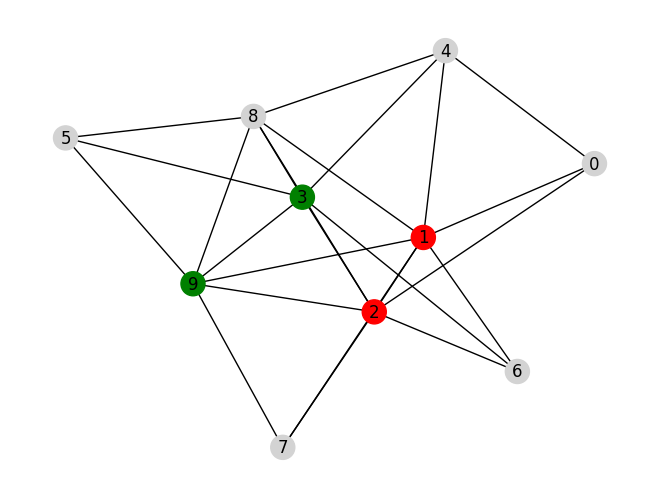

In [129]:
print("Original clustering")
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)

In [130]:
test_cluster_id_to_color

{0: 'red', 1: 'green'}

Below is the coarsened graph obtained from the previous clusters + original graph.

Original coarsened graph


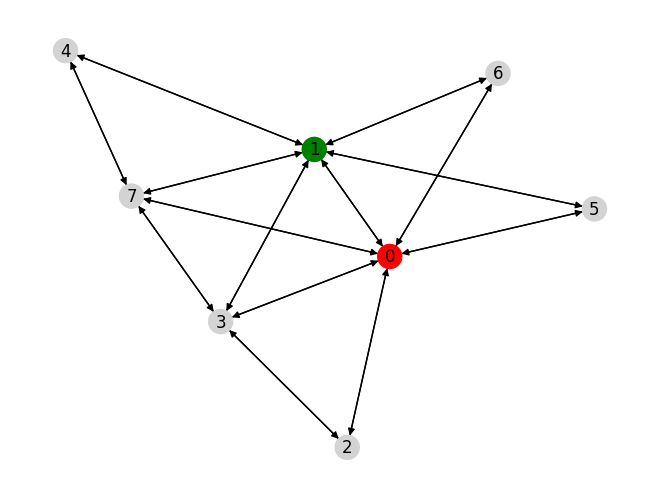

In [131]:
print("Original coarsened graph")
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

Below is a function which given the adjency matrix of some expanded graph $\tilde{G}_l$  creates the refined graph Data object $G_l$.  $\tilde{G}_l$ was obtained after expanding some $\tilde{G}_{l+1}$ using $v_{l+1}$. The new graph should contain the same edges as the expanded graph, but with labels indicating whether we should keep (1) or remove/refine them (-1). All edges can be represented as $e_l$. Node embeddings will then contain for each node the future expansion counts required, all node embeddings can therefore be represented as $v_l$ later on.

In [132]:
def refine_expanded_graph(expanded_adj: torch.Tensor, original_adj: torch.Tensor, v: torch.Tensor) -> Data:
    """
    expanded_adj: [N, N] dense adjacency (0/1)
    expanded_adj: [N, N] dense adjacency (0/1)
    v are the expansion counts for all nodes in graph Gl tilde, used to obtain Glm1
    
    returns: Data(x=[N,1], edge_index=[2, E])
    """
    edge_index, edge_attr = dense_to_sparse(expanded_adj)

    edge_labels = original_adj[edge_index[0],edge_index[1]].long() # [E], 1 if exists in original 0 otherwise
    edge_labels = edge_labels * 2 - 1 # remap 0/1 to -1/1, -1 means should be removed...

    #x = torch.zeros((expanded_adj.size(0), 1), dtype=torch.float)
    x = torch.zeros((expanded_adj.size(0), 1), dtype=torch.float)
    y = v.float()

    return Data(x=x, edge_index=edge_index, edge_attr=edge_labels, y=y)

test_refinedGraphData = refine_expanded_graph(test_expanded_graph_adj, test_graph_adj, test_v)
print(test_refinedGraphData.num_nodes)
print(".x:", test_refinedGraphData.x.shape)
print(".y:", test_refinedGraphData.y.shape)
print("edge_attr:", test_refinedGraphData.edge_attr)

10
.x: torch.Size([10, 1])
.y: torch.Size([8])
edge_attr: tensor([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
         1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
         1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
         1, -1,  1,  1])


Expanded and refined (red) graph coarsened graph
Cluster 0 has color red
Cluster 1 has color green


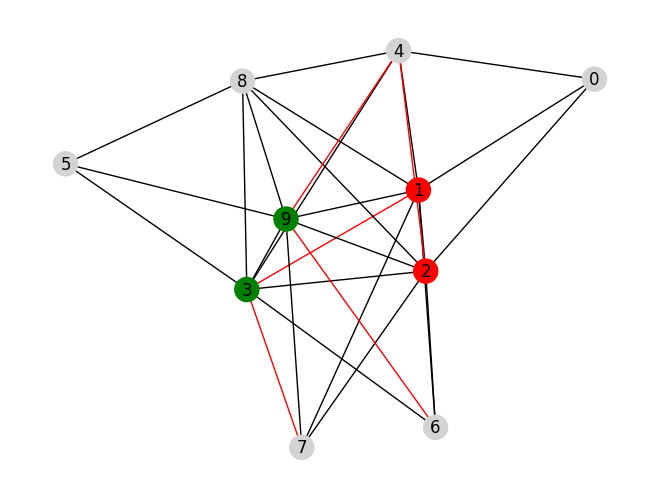

In [133]:
print("Expanded and refined (red) graph coarsened graph")
test_cluster_id_to_color = visualize_clusters(test_refinedGraphData, test_partitioning)

We can extract from the refined graph the vector $e_l$ and for each edge print its -1/1 value.

In [134]:
edge_index = test_refinedGraphData.edge_index   # shape [2, E]
edge_attr  = test_refinedGraphData.edge_attr    # shape [E] or [E,1]

for i in range(edge_index.size(1)):
    u = edge_index[0, i].item()
    v = edge_index[1, i].item()
    a = edge_attr[i].item() if edge_attr.ndim == 1 else edge_attr[i,0].item()
    print(f"Edge ({u:2d}, {v:2d})  → attr = {a}")

Edge ( 0,  1)  → attr = 1
Edge ( 0,  2)  → attr = 1
Edge ( 0,  4)  → attr = 1
Edge ( 1,  0)  → attr = 1
Edge ( 1,  2)  → attr = 1
Edge ( 1,  3)  → attr = -1
Edge ( 1,  4)  → attr = 1
Edge ( 1,  6)  → attr = 1
Edge ( 1,  7)  → attr = 1
Edge ( 1,  8)  → attr = 1
Edge ( 1,  9)  → attr = 1
Edge ( 2,  0)  → attr = 1
Edge ( 2,  1)  → attr = 1
Edge ( 2,  3)  → attr = 1
Edge ( 2,  4)  → attr = -1
Edge ( 2,  6)  → attr = 1
Edge ( 2,  7)  → attr = 1
Edge ( 2,  8)  → attr = 1
Edge ( 2,  9)  → attr = 1
Edge ( 3,  1)  → attr = -1
Edge ( 3,  2)  → attr = 1
Edge ( 3,  4)  → attr = 1
Edge ( 3,  5)  → attr = 1
Edge ( 3,  6)  → attr = 1
Edge ( 3,  7)  → attr = -1
Edge ( 3,  8)  → attr = 1
Edge ( 3,  9)  → attr = 1
Edge ( 4,  0)  → attr = 1
Edge ( 4,  1)  → attr = 1
Edge ( 4,  2)  → attr = -1
Edge ( 4,  3)  → attr = 1
Edge ( 4,  8)  → attr = 1
Edge ( 4,  9)  → attr = -1
Edge ( 5,  3)  → attr = 1
Edge ( 5,  8)  → attr = 1
Edge ( 5,  9)  → attr = 1
Edge ( 6,  1)  → attr = 1
Edge ( 6,  2)  → attr = 1
Edge (

# Creating SignNet node embeddings from graph for conditional diffusion

This code is adapted from their implementation.

In [135]:
class MLP(Module):
    """This block implements the multi-layer perceptron (MLP) module.

    Args:
        in_features (int): Number of features of the input.
        hidden_features (list[int]): List of the hidden features dimensions.
        out_features (int, optional): If not `None` a projection layer is added at the end of the MLP. Defaults to `None`.
        bias (bool, optional): Whether to use bias in the linear layers. Defaults to `True`.
        norm_layer (Module, optional): Normalization layer to use. Defaults to `norm_layer`.
    """

    def __init__(
        self,
        in_features: int,
        hidden_features: list[int],
        out_features: int | None = None,
        bias: bool = True,
        norm_layer=LayerNorm,
    ):
        super().__init__()
        lin_layers = []
        norm_layers = []
        hidden_in_features = in_features
        for hidden_dim in hidden_features:
            lin_layers.append(Linear(hidden_in_features, hidden_dim, bias=bias))
            norm_layers.append(norm_layer(hidden_dim))
            hidden_in_features = hidden_dim

        self.out_layer = (
            Linear(hidden_in_features, out_features, bias=bias)
            if out_features is not None
            else None
        )

        self.lin_layers = ModuleList(lin_layers)
        self.norm_layers = ModuleList(norm_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for lin, norm in zip(self.lin_layers, self.norm_layers):
            x = lin(x)
            x = norm(x)
            x = torch.relu(x)

        if self.out_layer is not None:
            x = self.out_layer(x)

        return x

In [136]:
class SignNet(Module):
    def __init__(
        self,
        num_eigenvectors: int,
        hidden_features: int,
        out_features: int,
        num_layers: int,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()

        self.in_layer = Linear(2, hidden_features)
        self.conv_layers = ModuleList(
            [
                GINConv(
                    MLP(hidden_features, [hidden_features, hidden_features]),
                    train_eps=True,
                )
                for _ in range(num_layers)
            ]
        )
        self.skip_layer = Linear(hidden_features * (num_layers + 1), hidden_features)
        self.dropout = Dropout(dropout)
        # the following corresponds to the ρ function in the paper
        self.merge_layer = MLP(
            in_features=num_eigenvectors * hidden_features,
            hidden_features=[hidden_features, hidden_features],
            out_features=out_features,
        )

    def forward(self, spectral_features, edge_index):
        """Forward pass of the model.

        Args:
            spectral_features (Tensor): Eigenvalues (repeated) concatenated with eigenvectors. Shape: :math:`(V, num_eigenvectors * 2)`.
            edge_index (Adj): Adjacency matrix given as edge index or sparse tensor. Shape: :math:`(2, E)` or :math:`(V, V)`.

        Returns:
            Tensor: Node features. Shape: :math:`(V, out_features)`.
        """
        # Stack spectral features
        eigenvalues_repeated, eigenvectors = spectral_features.chunk(
            2, dim=-1
        )  # (V, k), (V, k)

        positive_spectral_features = torch.stack(
            [eigenvalues_repeated, eigenvectors], dim=-1
        )  # V, k, 2
        negative_spectral_features = torch.stack(
            [eigenvalues_repeated, -eigenvectors], dim=-1
        )  # V, k, 2
        combined_spectral_features = torch.stack(
            [positive_spectral_features, negative_spectral_features]
        ).transpose(
            1, 2
        )  # 2, k, V, 2

        # Apply layers
        x = self.in_layer(combined_spectral_features)  # 2, k, V, hidden_features
        xs = [x]
        for conv in self.conv_layers:
            # apply conv layer to each spectral feature independently
            x = conv(x=x, edge_index=edge_index)
            xs.append(x)

        # Skip connection
        x = torch.cat(xs, dim=-1)
        x = self.dropout(x)
        x = self.skip_layer(x)  # 2, k, V, hidden_features
        # Make sign invariant
        x = x.sum(dim=0)  # k, V, hidden_features

        # Merge features
        x = x.transpose(0, 1)  # V, k, hidden_features
        x = self.merge_layer(x.reshape(x.size(0), -1))  # V, out_features

        return x

In [137]:
# define model
global_k = 8 # means the model takes as input 2x 32 = 64, we select first 32 eigenval/eigenvectors for all graphs
# and pad with 0s if needed, one node i will get [lambda 1, ..., lambda num_nodes-1, 0 ,..., u1(i), ..., un-1(i), 0, ..., 0]

# model input should be (V,2k) where k eigenvectors were selected, since some graphs might have less nodes than global_k we pad them with 0s...
# ideally with a big k we always have k>V and for each node the input vector will be 2k with first k values : [lambda 1, ..., lambda V, 0...0,     eigevec_0, ...., eigevec_V, 0...0]

# basically for each node, 
embedding_model = SignNet(
    num_eigenvectors=global_k,
    hidden_features=64,
    out_features=128,
    num_layers=3,
    dropout=0.1
)

In [142]:
def get_spectral_features_torch(data, k=global_k):
    N = data.num_nodes

    if N==1: return torch.randn((1, 2 * k), device=data.x.device)

    # Get Laplacian
    lap_edge_index, lap_edge_weight = get_laplacian(data.edge_index, num_nodes=N, normalization='sym') # computes laplacian and returns as edge_index with weights on each edge (pair of nodes)
    
    L_dense = to_dense_adj(lap_edge_index, edge_attr=lap_edge_weight, max_num_nodes=N).squeeze(0) # convert to matrix form
    # max_num_nodes guarantees the dense matrix is N×N even when some rows/columns are completely zero.
    
    # Compute eigendecomposition
    eigvals, eigvecs = torch.linalg.eigh(L_dense)  # eigenvalues sorted in ascending order, computes all 50 + their corresponding eigen vectors
    # shapes [num_nodes] and [num_nodes, num_nodes] resp. one column = one eigen vector
    
    # Take k smallest eigen values and corresponding vectors
    eigvals = eigvals[1:k+1] # [k,] (remove the 0 eigen value) / [num_nodes-1,] if num_nodes-1<k...
    eigvals = eigvals.unsqueeze(0) #[1,k]
    eigvals = eigvals.repeat(data.num_nodes, 1) # num_nodes, k / num_nodes, num_nodes-1  if num_nodes-1<k...

    eigvecs = eigvecs[:, 1:k+1] # [num_nodes, k] remove eigen vector linked with 0 eigen value /  [num_nodes, num_nodes-1] if num_nodes-1<k
    
    num_nodes = eigvecs.shape[0]
    num_vecs = eigvecs.shape[1] # could be num_nodes-1 and not k if  num_nodes-1<k    

    if num_vecs<k:
        # prepare padding matrix for both eigen values and eigen vectors
        diff = k-num_vecs
        pad_vals = torch.zeros((N, diff), device=eigvals.device)
        pad_vecs = torch.zeros((N, diff), device=eigvals.device)
        
        eigvals = torch.cat([eigvals, pad_vals], dim=1) # num_nodes, k
        eigvecs = torch.cat([eigvecs, pad_vecs], dim=1) # num_nodes, k

    try:
        return torch.cat([eigvals, eigvecs], dim=1) # (N, 2k)
    except RuntimeError as err:
        print("\n!!! spectral cat() failed !!!")
        print("graph id        :", data)
        print("data.num_nodes  :", data.num_nodes)
        print("eigvals shape   :", eigvals.shape)
        print("eigvecs shape   :", eigvecs.shape)
        print("full traceback follows\n")
        raise

# test
get_spectral_features_torch(test_graph, 100).shape

torch.Size([10, 200])

In [143]:
spectral_features = get_spectral_features_torch(test_graph, k=global_k)
print(spectral_features.shape)

embedding_model.eval()
with torch.no_grad():
    out = embedding_model(spectral_features, test_graph.edge_index)

print(out.shape) # for each node outputs some 128 dimensional embedding

torch.Size([10, 16])
torch.Size([10, 128])


The below function is O(n3)! Can be optimized using scipy.sparse.linalg.eigsh.

In [167]:
def fill_H_embeddings(G_expanded: Data, G_coarsened: Data, Plp1, embedding_model, rand=False):
    """
    Basically calculates embedding from Glp1 graph using embedding_model Signnet and algo5 from paper, then replicates these embeddings inside G_expanded
    all nodes belonging to a coarsened cluster will get that cluster embedding...
    Plp1 is the cluster/node mapping for transition Gl->Glp1

    G_expanded is the graph that needs to be filled!
    """
    
    num_nodes = G_coarsened.num_nodes
    if rand:
        #H = torch.randn(num_nodes)
        x = torch.randn((G_expanded.num_nodes, 128), G_expanded.x.device)
        G_expanded.x = x
        return G_expanded

    else:
        dev = next(embedding_model.parameters()).device
        
        spectral_feats = get_spectral_features_torch(G_coarsened, k=global_k).to(dev)
        edge_idx_dev   = G_coarsened.edge_index.to(dev)

        with torch.no_grad():
            H_coarsened = embedding_model(spectral_feats, edge_idx_dev)

        # broadcast using P_l that was used to obtain G_coarsened from G
        cluster_id = Plp1.argmax(dim=0).to(dev)
        H_expanded = H_coarsened[cluster_id] # Basically all nodes i in some cluster j with embedding Hj, will end up with embedding Hj 
        G_expanded.x = H_expanded.to(G_expanded.x.device) # set node embeddings
        
        return G_expanded

# test
test_graph = fill_H_embeddings(test_graph, test_coarsened_graph, test_P, embedding_model)
print(test_graph)

Data(x=[10, 128], edge_index=[2, 48])


# Creating the training dataset

The diffusion model will learn to denoise e_l (refine current graph), and v_l future expansions after refinement to get Gl-1, given the following parameters most contained in refined graph Gl:

* noised el and vl obtained from Gl˜ (noised T times using ddpm scheduler) (from refined graph which edges attr contain -1/1, and .y contains -1/1 for each potential node expansion)
* T
* Gl˜ node embeddings containing info obtained using coarsened Glp1 (.x inside refined graph)

In [145]:
class CoarsenDataset(IterableDataset): # torch dataset
    def __init__(self, graphsDataset, embedding_model, min_red=0.1, max_red=0.3, start=0, end=None, debug=False):
        super(CoarsenDataset).__init__()
        self.min_red = min_red
        self.max_red = max_red

        self.graphsDataset = graphsDataset
        self.embedding_model = embedding_model
        self.start = start
        self.end = len(graphsDataset) if end is None else end
        self.debug = debug

    def __iter__(self):
        iter_start = self.start
        iter_end = self.end
        graphsDataset = self.graphsDataset
        debug = self.debug

        selected_graphs = graphsDataset[iter_start: iter_end]
        
        for G0 in selected_graphs:
            coarsening_seq, contractions_history = rnd_red_seq(G0, self.min_red, self.max_red)

            if debug: print("coarsening_seq, contractions_history", len(coarsening_seq), len(contractions_history))
            # coarsening_seq = [G0, G1, ..., G_L]
            # contractions_history = [P1, P2, ..., P_{L}]  where P_l is used for G_{l-1}->G_l
            # P_l are the node-cluster mappings...

            num_initial_nodes = G0.num_nodes # target num nodes
            
            original_adj = get_graph_adj(G0.edge_index, G0.num_nodes)
        
            # to construct each sample we need:
            # from a sequence G{l-1} ---(Pl)---> Gl ----(Plp1)---> Glp1
            
            # first expand Glp1 using Plp1 -> and obtain Gl˜ before refinement
            # compare Gl˜ and Gl to get refined graph and extract e_l -> add that to graph Gl˜ to obtain refined graph with proper edge attributes which is denoted as Gl
            # Use Pl to compute next node expansion for Gl (the expansion that will lead to G{l-1}˜)

            # for last node we know v=[2]
            # then given refined graphs + node embeddings/edgeattributes resp. G1,G2....,G{l-1} we can learn to create resp. G0, ..., Gl-2
            # we don't need to learn how to create Gl-1 since given any single node graph GL we just duplicate it into two nodes and that gives Gl-1...
            # therefore we can reconstruct any sequence backwards if model learns to reproduce the refinement+future expansion steps...

            for i in range(1, len(contractions_history)-1): # 1, ..., L-2
                Glm1 = coarsening_seq[i-1] # G0, G1, ..., Gl-3
                Gl = coarsening_seq[i] #  G1, G2, ..., Gl-2
                Glp1 = coarsening_seq[i+1] # G2, G3, ..., Gl-1
                Pl = contractions_history[i-1] # used to coarsen Glm1 into Gl,    P1...Pl-2
                Plp1 = contractions_history[i] # used to coarsen Gl into Glp1,   P2, ..., Pl-1

                original_graph_adj_Gl = get_graph_adj(Gl.edge_index, Gl.num_nodes) # original Gl adjency matrix
                expanded_graph_adj_Gl_tilde = expand_coarsened(Glp1, Plp1) # Gl tilde, using actual cluster values, #G1...Gl-2 tilde
                # we expand using Plp1 (that is vlp1 expansion counts for all nodes)
                
                if debug: print("Gl.num_nodes", Gl.num_nodes)
                
                #vlp1 = compute_node_embeddings(Plp1) # extract cluster sizes -1/1 if need to expand, of Glp1
                v_parent = compute_node_embeddings(Pl) # future node expansions of Gl tilde, used to obtain Glm1
                if debug: print("v_parent.shape: ", v_parent.shape)

                refined_graph = refine_expanded_graph(expanded_graph_adj_Gl_tilde, original_graph_adj_Gl, v_parent) # Gl refined version ,  G1, G2, ..., Gl-2
                if debug: print("refined_graph.num_nodes: ", refined_graph.num_nodes)

                # data object, is refined G_l containing e_l edge attr 1 keep /-1 remove; future vl expansion labels on each node in .y, missing node embeddings obtained from Glp1 and replicated 
                # across all cluster nodes
                refined_graph = fill_H_embeddings(refined_graph, Glp1, Plp1, embedding_model) # adds all node embeddings inside Gl refined graph according to algo 5, using its later coarsened version Glp1
                # as well as Plp1 transition and the embedding model

                pho = (Glm1.num_nodes - Gl.num_nodes) / Gl.num_nodes # proportion of nodes that were removed
                # from Glm1 to obtain Gl
            
                yield refined_graph, num_initial_nodes, pho

In [146]:
def coarsen_collate(samples):
    """
    samples: list of tuples (refined_graph, init_num_nodes, level_l)
    returns batch_graph PyG Batch object with all graphs merged;
    init_N      : LongTensor [B]  –  original |V(G0)| for all graphs in batch
    pho_l     : LongTensor [B]  –  coarsening prop. % of nodes removed to obtain current graph
    """
    graphs, init_nodes, levels = zip(*samples)

    batch_graph = Batch.from_data_list(graphs)  # automatic concat
    init_N = torch.tensor(init_nodes, dtype=torch.long)
    pho_l = torch.tensor(levels, dtype=torch.long)

    return batch_graph, init_N, pho_l

In [147]:
dataset = CoarsenDataset(graphsDataset=erdos_renyi_dataset,embedding_model=embedding_model)
loader  = torchDataLoader(dataset,batch_size=32,collate_fn=coarsen_collate,num_workers=0)

num_workers available:  4


In [148]:
for batch_graph, init_N, pho_l in loader:
    print("batch_graph: ", batch_graph)
    print("init_N: ", init_N)
    print("pho_l ", pho_l)
    break

graphs = batch_graph.to_data_list()

print("\nNum nodes in each graph of batch:")
for g in graphs:
    print(g.num_nodes, g.y.shape)

batch_graph:  DataBatch(x=[169, 128], edge_index=[2, 712], edge_attr=[712], y=[169], batch=[169], ptr=[33])
init_N:  tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
pho_l  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Num nodes in each graph of batch:
8 torch.Size([8])
6 torch.Size([6])
4 torch.Size([4])
3 torch.Size([3])
8 torch.Size([8])
6 torch.Size([6])
4 torch.Size([4])
3 torch.Size([3])
8 torch.Size([8])
6 torch.Size([6])
4 torch.Size([4])
3 torch.Size([3])
8 torch.Size([8])
5 torch.Size([5])
3 torch.Size([3])
8 torch.Size([8])
5 torch.Size([5])
3 torch.Size([3])
8 torch.Size([8])
5 torch.Size([5])
4 torch.Size([4])
3 torch.Size([3])
7 torch.Size([7])
5 torch.Size([5])
4 torch.Size([4])
3 torch.Size([3])
8 torch.Size([8])
6 torch.Size([6])
4 torch.Size([4])
3 torch.Size([3])
8 torch.Size([8])
6 torch.Size([6])


In [149]:
print(batch_graph.x.shape)
print(batch_graph.y.shape)
print(batch_graph.edge_index.shape)

torch.Size([169, 128])
torch.Size([169])
torch.Size([2, 712])


# Defining denoising model

In [ ]:
class Denoiser(Module):
    """
    Simple edge-aware denoiser for (v_l, e_l).

    • Each node input  : [H_node | v_noisy | t_emb | scalar_emb]
    • Each edge message: concatenates (h_src,h_dst) and feeds e_noisy to
                         TransformerConv via edge_attr.
    """
    def __init__(self, in_dim, hid_dim=128,
                 t_emb_dim=32, n_heads=4):
        super().__init__()

        # --- tiny embeddings for timestep -------------------------------
        self.t_embed   = Linear(1, t_emb_dim)   # γ(t)
        self.scalar_ml = Linear(2, t_emb_dim)   # γ(|V(G₀)|, φ_l)

        # --- 2 × TransformerConv (edge_dim=1 → uses e_noisy) ------------
        self.conv1 = TransformerConv(in_channels  = in_dim + 1 + 2*t_emb_dim,
                                     out_channels = hid_dim,
                                     heads        = n_heads,
                                     edge_dim     = 1,
                                     concat=False)

        self.conv2 = TransformerConv(in_channels  = hid_dim,
                                     out_channels = hid_dim,
                                     heads        = n_heads,
                                     edge_dim     = 1,
                                     concat=False)

        # --- prediction heads -------------------------------------------
        self.node_head = Sequential(Linear(hid_dim, hid_dim),
                                     ReLU(),
                                     Linear(hid_dim, 1))

        self.edge_head = Sequential(Linear(2*hid_dim, hid_dim),
                                     ReLU(),
                                     Linear(hid_dim, 1))

    # ------------------------------------------------------------------ #
    def forward(self, data, t_node, t_edge, init_N, pho_l):
        """
        data.y         : v_noisy   (ΣN,)
        data.edge_attr : e_noisy   (ΣE,)
        """

        # -------- build node-feature tensor ------------------------------
        v_feat = data.y.unsqueeze(1)                             # (ΣN,1)

        t_feat = self.t_embed(t_node.unsqueeze(1).float())       # (ΣN,t)
        scalars = torch.stack([init_N[data.batch].float(),
                               pho_l[data.batch].float()], dim=1)
        s_feat  = self.scalar_ml(scalars)                        # (ΣN,t)

        x0 = torch.cat([data.x, v_feat, t_feat, s_feat], dim=1)  # (ΣN,d₀)

        # -------- message passing (edge_dim = 1 uses e_noisy) ------------
        h = self.conv1(x0, data.edge_index, data.edge_attr.unsqueeze(-1))
        h = self.conv2(h,  data.edge_index, data.edge_attr.unsqueeze(-1))

        # -------- node noise prediction ----------------------------------
        node_eps = self.node_head(h).squeeze(-1)                 # (ΣN,)

        # -------- edge noise prediction ----------------------------------
        src, dst = data.edge_index
        edge_h   = torch.cat([h[src], h[dst]], dim=1)            # (ΣE,2H)
        edge_eps = self.edge_head(edge_h).squeeze(-1)            # (ΣE,)

        return node_eps, edge_eps

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [152]:
model  = Denoiser(in_dim=batch_graph.x.size(1)).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=10e-4) # same as paper

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
scheduler.set_timesteps(1000)

# Training model

In [153]:
T = scheduler.config.num_train_timesteps   # e.g. 1000
all_losses = [] 

for batch_graph, init_N, pho_l in loader:
    batch_graph = batch_graph.to(device, non_blocking=True) 
    B = init_N.size(0) # batch size

    t_graph = torch.randint(0, T, (B,) , device=device) # per batch T sampling

    # batch_graph.x.size(0), contains for each graph in batch its num_nodes
    # we sample coordinate-wise (for each node/edge) time levels, each node gets noised using a different ti, which we 
    # will of course provide to the model after...
    
    #t_node = torch.randint(0, T, (batch_graph.x.size(0),),  device=device)
    #t_edge = torch.randint(0, T, (batch_graph.edge_attr.size(0),), device=device)

    t_node = t_graph[batch_graph.batch]                         # [ΣN]
    src    = batch_graph.edge_index[0]                          # src node of each edge
    t_edge = t_graph[batch_graph.batch[src]]                    # [ΣE]

    # expansion v_l and refinement e_l vectors, will be noised soon
    clean_v = batch_graph.y.float() # [Σ num_nodes]
    clean_e = batch_graph.edge_attr.float() # [Σ num_edges]

    # prepare random gaussian noise to add to each node/edge using same sized vectors
    noise_v = torch.randn_like(clean_v)
    noise_e = torch.randn_like(clean_e)

    # add noise using hf ddpm scheduler using all different sampled time steps
    v_noisy = scheduler.add_noise(clean_v.unsqueeze(-1),  # [Σ num_nodes,1]
                                  noise_v.unsqueeze(-1),
                                  t_node).squeeze(-1)     # back to [num_nodes]

    # for e_l refinement vectors too
    e_noisy = scheduler.add_noise(clean_e.unsqueeze(-1),  # [Σ num_edges,1]
                                  noise_e.unsqueeze(-1),
                                  t_edge).squeeze(-1)     # back to [Σ num_edges]

    data_t = batch_graph.clone()
    data_t.y = v_noisy 
    data_t.edge_attr = e_noisy

    # predict noise
    pred_v_eps, pred_e_eps = model(data_t,
                                   t_node, t_edge,
                                   init_N.to(device),
                                   pho_l.to(device))

    # l2 loss
    loss  = (pred_v_eps - noise_v).pow(2).mean() + \
            (pred_e_eps - noise_e).pow(2).mean()
    all_losses.append(loss.item()) 

    # backprop
    opt.zero_grad()
    loss.backward()
    opt.step()

Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba2a212da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba2a212da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more edges to contract in rnd_red_seq
Error no more

Plot loss

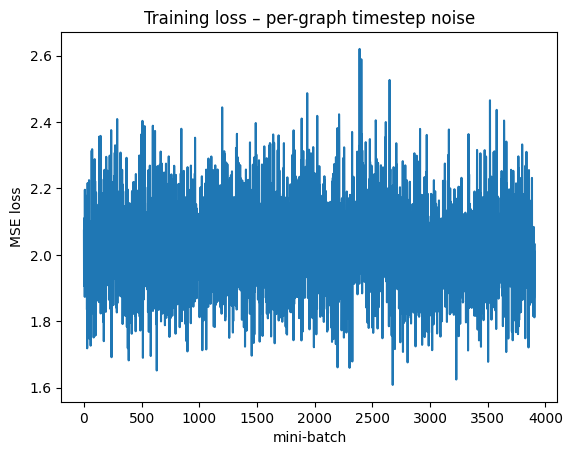

In [165]:
import matplotlib.pyplot as plt
plt.plot(all_losses[1000:])
plt.xlabel("mini-batch")
plt.ylabel("MSE loss")
plt.title("Training loss – per-graph timestep noise")
plt.show()

# Generating new graphs

Seed GL graph. Create GLm1 from GL single node graph and initialize its embeddings properly.

In [155]:
def seed_graph(feat_dim: int = 128) -> Data:
    """Returns GL (one node self edge? expansion true), GL-1 two nodes one edge"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    edge_index_GL = torch.empty((2, 0), dtype=torch.long)
    GL_graph = Data(x=torch.randn(1), edge_index=edge_index_GL, num_nodes=1) # single node graph, only created to apply fill_H_embeddings
    # PL
    PL = torch.tensor([[1, 1]]) # both nodes of GLm1 belong to same cluster node, the only in GL

    # create GLm1seed_graph
    edge_index = torch.tensor([[0, 1],
                               [1, 0]], dtype=torch.long, device=device)
    x   = torch.zeros((2, feat_dim), device=device)
    # need to pass through embedding func here instead?
    
    y   = torch.ones(2, device=device) # v_l 1s only keep
    e_a = torch.ones(2, device=device) # e_l one only keep, 2 because undirected edge
    
    GLm1 = Data(x=x, edge_index=edge_index,
                edge_attr=e_a,  y=y)

    GLm1 = fill_H_embeddings(GLm1, GL_graph, PL, embedding_model)
    return GLm1

# test
test_GLm1 = seed_graph()
print(test_GLm1)

Data(x=[2, 128], edge_index=[2, 2], edge_attr=[2], y=[2])


In [156]:
test_GLm1.edge_index

tensor([[0, 1],
        [1, 0]], device='cuda:0')

Obtain model predictions on GLm1 for a single denoising step

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [158]:
print(device)
T = scheduler.config.num_train_timesteps 

test_init_N = torch.tensor([20], device=device)
test_pho_l = torch.tensor([0.15], device=device) # during generation we will sample pho randomly

# create a batch containing single graph GLm
G_batched  = Batch.from_data_list([test_GLm1]).to(device) #, device=device)
t_graph = torch.randint(0, T, (1,), device=device) # noise number of timesteps

t_node  = t_graph.expand(test_GLm1.num_nodes)                    # [N]
src     = test_GLm1.edge_index[0]
t_edge  = t_graph.expand(src.size(0))                     # [E]


# expansion v_l and refinement e_l vectors, will be noised soon
clean_v = test_GLm1.y.float().to(device) # [num_nodes]
clean_e = test_GLm1.edge_attr.float().to(device) # [num_edges]

# prepare random gaussian noise to add to each node/edge using same sized vectors
noise_v = torch.randn_like(clean_v, device=device)
noise_e = torch.randn_like(clean_e, device=device)

# add noise using hf ddpm scheduler using all different sampled time steps
v_noisy = scheduler.add_noise(clean_v.unsqueeze(-1),  # [num_nodes,1]
                              noise_v.unsqueeze(-1),
                              t_node).squeeze(-1)     # back to [num_nodes]

# for e_l refinement vectors too
e_noisy = scheduler.add_noise(clean_e.unsqueeze(-1),  # [num_edges,1]
                              noise_e.unsqueeze(-1),
                              t_edge).squeeze(-1)     # back to [num_edges]


test_pred_v_Lm1, test_pred_e_Lm1 = model(
        G_batched,
        t_node, t_edge,
        test_init_N, test_pho_l)

test_pred_v_Lm1[1] += 10e-7
print(test_pred_v_Lm1)
print(test_pred_e_Lm1)

cuda
tensor([0.0292, 0.0292], device='cuda:0', grad_fn=<AsStridedBackward0>)
tensor([-0.0040, -0.0040], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [159]:
import torch, torch_geometric
print("torch:", torch.__version__, "cuda?", torch.cuda.is_available())
print("pyg  :", torch_geometric.__version__)

# where do the model parameters live?
print(next(model.parameters()).device)              # should say cuda:0

# but the aggregated messages kernel tells the truth:
from torch_geometric.nn.conv.gat_conv import GATConv
print("GATConv uses fused CUDA kernels? ",
      GATConv.__dict__.get('_FUSED_KERNEL', False))

torch: 2.6.0+cu124 cuda? True
pyg  : 2.6.1
cuda:0
GATConv uses fused CUDA kernels?  False


Discretize model predictions

In [160]:
@torch.no_grad()
def discretise(v_cont: torch.Tensor, e_cont: torch.Tensor,
               n_dup: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Turn continuous outputs into {-1,+1}.
    - v_cont (N,)  higher and closer to 1 means we should expand
    - e_cont – (E,)  positive means we should keep, negative means we should refine
    - n_dup number of nodes to expand (duplicate since edge contraction)
    """
    
    # discretize v_l
    thr_v, _ = torch.topk(v_cont, k=n_dup, largest=True) # fetches top k=n_dup values, closest to +1 should be expanded
    
    # returns values and indices in two tensors
    
    v_bin = torch.full_like(v_cont, -1.) # by default all nodes should not be duplicated
    v_bin[v_cont >= thr_v[-1]] = 1.0 # all the top-k are set to 1 to be expanded
    # here if 

     # discretize e_l
    e_bin = torch.where(e_cont > 0, torch.tensor(1.0, device=e_cont.device),
                                    torch.tensor(-1.0,device=e_cont.device)) # edge refinement classification
    return v_bin, e_bin

# test
test_disc_v_Lm1, test_disc_e_Lm1 = discretise(test_pred_v_Lm1, test_pred_e_Lm1, 1) # duplicate max 1 node for instance...
print(test_disc_v_Lm1)
print(test_disc_e_Lm1)

tensor([-1.,  1.], device='cuda:0')
tensor([-1., -1.], device='cuda:0')


First apply the refinement step using discretized e_l vector.

Cluster 0 has color red
Cluster 1 has color green


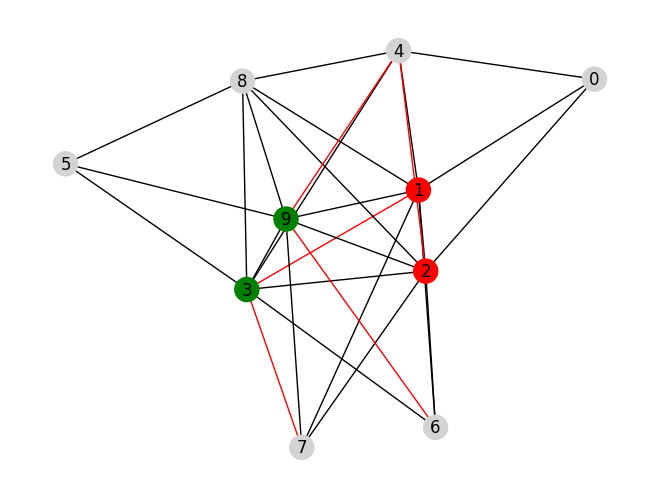

Cluster 0 has color red
Cluster 1 has color green


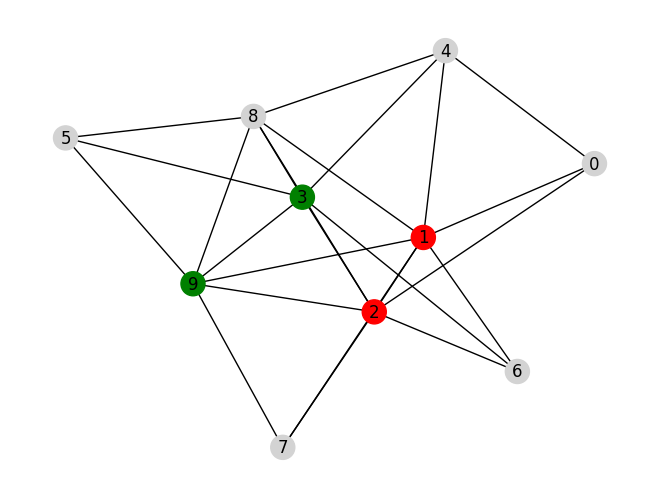

{0: 'red', 1: 'green'}

In [161]:
def drop_edges(G: Data, disc_e: torch.Tensor) -> Data:
    keep = disc_e > 0 # [E] booleans

    if keep.sum() == 0:  # keep at least one edge
        keep[disc_e.argmax()] = True

    # G.edge_index [2, E]
    
    # slice edge_index & edge_attr
    edge_index_ref = G.edge_index[:, keep]  # (2 , E_keep)
    edge_attr_ref  = G.edge_attr[keep]      # (E_keep,)

    G_refined = Data(
        x          = G.x,
        edge_index = edge_index_ref,
        edge_attr  = edge_attr_ref,
        y          = G.y
    )

    return G_refined

# test using old graph
visualize_clusters(test_refinedGraphData, test_partitioning)
test_edges_removed_graph = drop_edges(test_refinedGraphData, test_refinedGraphData.edge_attr) # first refine graph Gltilde
visualize_clusters(test_edges_removed_graph, test_partitioning)

Building P matrix from discretized v to expand graph. We have GLm1tilde right now, to expand it we can reuse PLm1 (proj matrix used to create GLm1) but we need to create it using sampled vLm1.

In [162]:
def build_Pl_from_vl(v_bin: torch.Tensor) -> torch.Tensor:
    """
    build Pl from vl where Pl is used to obtain Gl from Glm1, and vl is the expansion counts of Gl nodes to obtain Glm1

    v_bin discretized version (N,) (-1 keep, +1 duplicate)
    returns P [N, Ne] where Ne is the number of nodes after expansion
    P is the cluster-node mapping, nodes are created in expanded graph and mapped to cluster nodes from current graph
    cluster nodes are represented by v_bin

    each row sums to 1 or 2 (solo cluster / cluster that needs expansion to two nodes)
    each column has exactly one 1 in some cluster row, for each new node in expanded graph (Glm1)
    """
    
    N = v_bin.numel()
    copies_per_node = (v_bin > 0).long() + 1 # {-1,+1} → {1,2} (N,)
    Ne = copies_per_node.sum().item() # total #nodes after expand

    P = torch.zeros((N, Ne), dtype=torch.float32)

    col = 0                                            # current fine-node id
    for cluster_id, n_copies in enumerate(copies_per_node.tolist()): # for each cluster node i=0...N-1
        for _ in range(n_copies): # 1× or 2×
            P[cluster_id, col] = 1.0 # add 1 to represent node in cluster 
            col += 1 # next free column

    return P

# test
test_PLm1 = build_Pl_from_vl(test_disc_v_Lm1)
print(test_PLm1) # PLm1 is used to coarsen GLm2 into GLm1

tensor([[1., 0., 0.],
        [0., 1., 1.]])


Expand graph and fill with new embeddings

In [168]:
test_GLm2_adj = expand_coarsened(test_edges_removed_graph, test_PLm1) # then expand graph GLm1 into GLm2 using PLm2

# convert to graph Data object
edge_index, edge_attr = dense_to_sparse(test_GLm2_adj)
x = torch.zeros((test_GLm2_adj.size(0), 1), dtype=torch.float)
test_GLm2 = Data(x=x, edge_index=edge_index, edge_attr=edge_attr) # edge_attr and .y do not matter since they are predicted
# however it is missing embeddings for next model prediction...

GLm2 = fill_H_embeddings(test_GLm2, test_GLm1, test_PLm1, embedding_model) # this function is given some Gl, and its vl 
# and it returns embeddings for Glm1 in the paper, here we use Plm1 instead of vl and input GLm1 to calculate 
# GLm2's embeddings...

print(GLm2.num_nodes)

3


## Implementing algo 7

In [169]:
def denoise_one_step(G_t: Data, t: int, model, scheduler, init_N: int, pho_l: float, device: torch.device):
    """
    Computes a single reverse DDPM step on v_l and e_l.
    Returns the denoised G_t graph.
    """

    # use same timestep for all nodes/edges
    t_node = torch.full((G_t.x.size(0),), t, dtype=torch.long, device=device) # [num_nodes] contains repeated t value
    t_edge = torch.full((G_t.edge_attr.size(0),), t, dtype=torch.long, device=device) # [num_edges] contains repeated t value

    init_N_tensor = torch.tensor([init_N], dtype=torch.long, device=device) # target size of G0
    pho_tensor    = torch.tensor([pho_l],  dtype=torch.long, device=device) # sampled reduction frac

    batch = Batch.from_data_list([G_t]).to(device) # wrap graph in batch

    eps_v, eps_e = model(batch, t_node, t_edge, init_N_tensor, pho_tensor) # predicted noise for one step

    v_in   = G_t.y.unsqueeze(-1) # (num_nodes,1) 
    step_v = scheduler.step(eps_v.unsqueeze(-1), t, v_in) # noise v
    v_tm1  = step_v.prev_sample.squeeze(-1) # (num_nodes,) applies denoising

    e_in   = G_t.edge_attr.unsqueeze(-1) # (num_edges,1)
    step_e = scheduler.step(eps_e.unsqueeze(-1),
                            t, e_in)
    e_tm1  = step_e.prev_sample.squeeze(-1) # (num_edges,) applies denoising

    G_tm1 = Data(x = G_t.x, edge_index = G_t.edge_index, edge_attr  = e_tm1, y = v_tm1)

    return G_tm1

In [172]:
def sample_graph(init_N: int, model, scheduler, min_red: float = 0.10, max_red: float = 0.30, feat_dim: int = 128) -> Data:
    """
    Generates a graph with ≈ init_N nodes using the trained denoiser.
    """
    device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model   = model.to(device).eval()
    T       = scheduler.config.num_train_timesteps

    G_l = seed_graph(feat_dim) #GLm1 with two vertices, one edge
    
    # ----------------------------------------------------------------------
    # loop over levels  l = L-1 , … , 1 (stop when #V >= init_N)
    # ----------------------------------------------------------------------
    while G_l.num_nodes < init_N:

        pho_l = float(torch.empty(1).uniform_(min_red, max_red)) # sample between min_red and max_red
        # represents reduction % of previous coarsening step

        # calculate future duplication count to match pho_l
        Nc = G_l.num_nodes
        Ne = Nc / (1 - pho_l)

        n_dup = (Ne-Nc) # since each expansion adds 1 to node count, converts tensor
        n_dup   = int(max(round(Ne - Nc), 1)) # at least one duplication 

        G_t = G_l.clone()
        G_t.y = torch.randn(G_l.num_nodes, device=device)
        G_t.edge_attr = torch.randn(G_l.edge_attr.size(0), device=device)

        for t in trange(T-1, -1, -1, leave=False): # reverse diffusion process
            G_t = denoise_one_step(G_t, t, model, scheduler, init_N, pho_l, device)

        v_bin, e_bin = discretise(G_t.y, G_t.edge_attr, n_dup) # discretize and make sure to only keep n_dup

        G_ref = drop_edges(G_l, e_bin).to(device) # drop selected edges

        # expand graph
        P_l   = build_Pl_from_vl(v_bin).to(device) # [Nc,Ne] cluster-node mapping
        adj   = expand_coarsened(G_ref, P_l).to(device) 
        ei, _ = dense_to_sparse(adj)

        G_fine = Data(x=torch.zeros((adj.size(0), feat_dim), device=device), edge_index=ei, 
                      edge_attr=torch.ones(ei.size(1), device=device)*-1, y = torch.ones(adj.size(0), device=device)*-1)

        # G_fine is expanded version of G_ref 
        G_fine = fill_H_embeddings(G_fine, G_ref, P_l, embedding_model) # fill new embeddings from coarsened graph

        G_l = G_fine
        print(G_l.num_nodes)

    return G_l.to("cpu")

In [175]:
sample_G = sample_graph(10, model, scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

3


  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

5


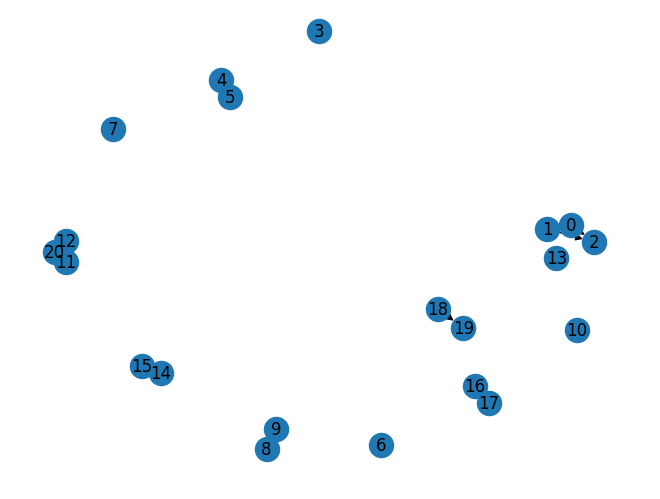

In [174]:
nx.draw(to_networkx(sample_G), with_labels=True)